Missing data %: 
 class                    0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.121387
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.184971
gill-spacing            41.040462
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.393064
stem-surface            62.427746
stem-color               0.000000
veil-type               94.797688
veil-color              87.861272
has-ring                 0.000000
ring-type                4.046243
spore-print-color       89.595376
habitat                  0.000000
season                   0.000000
dtype: float64


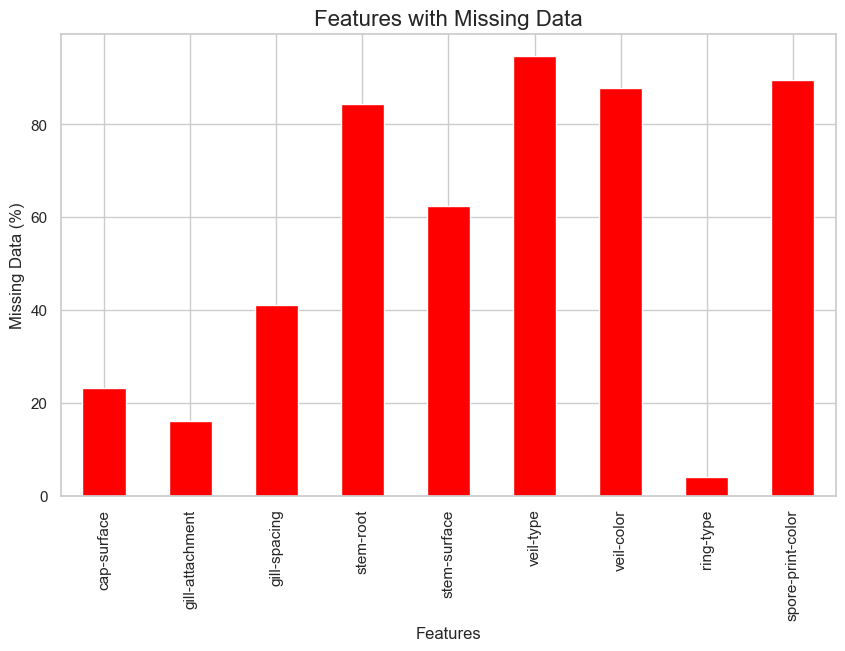

<bound method NDFrame.head of       class  cap-diameter cap-shape cap-color does-bruise-or-bleed  \
0         p         20.91         f         k                    t   
1         p         18.53         s         g                    t   
2         p         18.04         s         k                    t   
3         p         17.59         f         g                    t   
4         p         17.31         s         n                    t   
...     ...           ...       ...       ...                  ...   
61064     p          0.49         x         y                    f   
61065     p          0.48         x         o                    f   
61066     p          0.48         x         y                    f   
61067     p          0.44         x         y                    f   
61068     p          0.38         x         o                    f   

      gill-attachment gill-color  stem-height  stem-width stem-color has-ring  \
0                   d          b         5.35   

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load in csv data
original_data = pd.read_csv("MushroomDataset\comma_secondary_data.csv")

# Determine how much data is missing from each feature
missing_info = original_data.isnull().sum() / len(original_data) * 100

# Can print to analyze
print ("Missing data %: \n", missing_info)

# Drop below threshold
threshold = 20
features_to_drop = missing_info[missing_info > threshold].index
data_drop_feature = original_data.drop(columns=features_to_drop)


# Plot the missing data percentage for features with missing data above the threshold
features_with_missing = missing_info[missing_info > 0]
plt.figure(figsize=(10, 6))
features_with_missing.plot(kind='bar', color='red')
plt.title(f"Features with Missing Data", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Missing Data (%)", fontsize=12)
plt.xticks(rotation=90)  # Rotate the feature names for better readability
plt.show()


In [ ]:
# Search samples for missing or incomplete data
missing_row = data_drop_feature.isnull().sum(axis=1)

# dropping samples with any missing features
rows_to_drop = data_drop_feature[missing_row > 0].index
data_clean = data_drop_feature.drop(index=rows_to_drop)

print("Original Data shape: ", original_data.shape)
print("Samples Dropped: " , rows_to_drop.shape)
print("Cleaned Data Shape: ", data_clean.shape)

#data_clean.to_csv("first_cleaning.csv", index=False)

Original Data shape:  (61069, 21)
Samples Dropped:  Index([   74,    81,    85,    87,    89,    93,   102,   104,   105,   108,
       ...
       61059, 61060, 61061, 61062, 61063, 61064, 61065, 61066, 61067, 61068],
      dtype='int64', length=12002)
Cleaned Data Shape:  (49067, 14)


In [ ]:
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Dictionary to store encoding keys
encoding_dict = defaultdict(dict)

# Break down the categories
categorical_features = ['cap-shape', 'cap-color', 'gill-attachment', 'gill-color', 'stem-color', 'ring-type', 'habitat', 'season']
numerical_features = ['cap-diameter', 'stem-height', 'stem-width']
boolean_features = ['does-bruise-or-bleed', 'has-ring']
target_class = ['class']

# Drop outliers
z_threshold = 3
z_scores = np.abs(stats.zscore(data_clean[numerical_features]))
outliers = (z_scores > 3).any(axis=1)
print(f'Dropping {outliers.sum()} outliers in data')
data_clean = data_clean[~outliers]
print("New data shape: ", data_clean.shape)


# Change target from p / e to 1 / 0
data_clean[target_class[0]] = data_clean[target_class[0]].map({'p':1, 'e':0})

# Print to see split 1 = poisonous 0 = edible
print(data_clean[target_class[0]].value_counts())

# Convert boolean
for feature in boolean_features:
    data_clean[feature] = data_clean[feature].map({'t': 1, 'f': 0})
    encoding_dict[feature] = {'t': 1, 'f': 0}


Dropping 2016 outliers in data
New data shape:  (47051, 14)
class
1    26264
0    20787
Name: count, dtype: int64


In [ ]:
# Encode categorical features
for feature in categorical_features:
    # Create encoding & store in dictionary
    encoding_map = data_clean.groupby(feature)[target_class[0]].mean()
    encoding_dict[feature] = encoding_map.to_dict()

    # Apply encoding
    data_clean[feature] = data_clean[feature].map(encoding_dict[feature])


In [ ]:

# Standardize numerical features
scaler = StandardScaler()
scaler.fit(data_clean[numerical_features])
data_clean[numerical_features] = scaler.transform(data_clean[numerical_features])

# Store scaling info & add to dictionary
scaling_info = {}
for i, feature in enumerate(numerical_features):
    scaling_info[feature] = {
         'mean': scaler.mean_[i],
         'std': scaler.scale_[i]
    }
encoding_dict['scaling'] = scaling_info

for feature in numerical_features:
    min = data_clean[feature].min()
    max = data_clean[feature].max()
    print(f"Min: {min} \tMax: {max}")



data_clean.to_csv("clean_mushroom_data.csv", index=False)

Min: -1.6066858441680394 	Max: 4.589122831282251
Min: -2.5254325803810223 	Max: 3.868756393778493
Min: -1.410812605571531 	Max: 3.9286453654100812
       cap-diameter   stem-height    stem-width
count  4.705100e+04  4.705100e+04  4.705100e+04
mean   2.899496e-17 -9.664988e-17 -1.111474e-16
std    1.000011e+00  1.000011e+00  1.000011e+00
min   -1.606686e+00 -2.525433e+00 -1.410813e+00
25%   -7.543238e-01 -6.343677e-01 -7.445851e-01
50%   -1.312364e-01 -1.317317e-01 -1.928090e-01
75%    5.188245e-01  4.821434e-01  5.408846e-01
max    4.589123e+00  3.868756e+00  3.928645e+00
